Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Brain tumor 3D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](https://raw.githubusercontent.com/Project-MONAI/tutorials/8b90a16d82a463551d81dd4da200f3d406c6843e/figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb)

## Set Parameters

In [1]:
import os

PROJECT_DIRECTORY = "/content/drive/MyDrive/custom-sam-3d/"
# set this to the location of the project directory.
# Locally this should be your current working directory.
# In Google Colab this should start with "/content/drive/MyDrive/<rest-of-path>"

DATA_DIRECTORY = None
# set this to the name of the data directory

DOWNLOAD = True
# set to true if you do not already have data in DATA_DIRECTORY

MODEL_DIRECTORY = os.path.join(PROJECT_DIRECTORY, 'models')
# set location to save/load models and checkpoints.

CHECKPOINT_MODEL_NAME = "model_checkpoint.pth"
# set the name of the saved training model

CHECKPOINT_OPTIMIZER_NAME = "optimizer.pth"
# set the name of the saved training optimizer

CHECKPOINT_LEARNING_RATE_SCHEDULER_NAME = "lr_scheduler.pth"
# set the name of the saved training learning rate scheduler

CHECKPOINT_STATS_NAME = "stats.pth"
# set the name of the saved training checkpoint

BEST_MODEL_NAME = "best_model.pth"
# set the name of the saved best model

LOAD_PREVIOUS_CHECKPOINT = True # True
# Leave False if you want to restart training from scratch.
# Change to True if you want to continue training from most recent epoch checkpoint.

MAX_EPOCHS = 12 # 300
# maximum epochs to be trained
# if resuming training from epoch 8 and MAX_EPOCHS is 10, only 2 epochs of training are performed

RANDOM_SEED = 1000
# TODO : save and load random states during training

VAL_EVERY = 1
# how many epochs between each validation run

PRINT_EVERY = 10
# controls how often each batch loss is printed during training
# set to 1 to print every step's training loss
# TODO: set to -1 to print no training loss

## Setup environment
#### Run the first code block below if running on Google Colab and project is saved to your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cd $PROJECT_DIRECTORY

%load_ext autoreload
%autoreload 2

!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!matplotlib inline

Mounted at /content/drive
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 93.

In [3]:
import sys

if PROJECT_DIRECTORY not in sys.path:
    sys.path.insert(0, PROJECT_DIRECTORY)

## Setup imports

In [4]:
# import os
# import shutil
import tempfile
import time
import random
import matplotlib.pyplot as plt
# from monai.apps import DecathlonDataset
# from monai.config import print_config
from monai.data import decollate_batch # , DataLoader
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
# from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
#     Activationsd,
    AsDiscrete,
#     AsDiscreted,
    Compose,
#     CenterSpatialCropd,
#     Invertd,
#     LoadImaged,
#     MapTransform,
#     NormalizeIntensityd,
#     Orientationd,
#     RandFlipd,
#     RandScaleIntensityd,
#     RandShiftIntensityd,
#     RandSpatialCropd,
#     Spacingd,
#     EnsureTyped,
#     EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch
# import torch.nn as nn
# import torch.nn.functional as F

# print_config()

## Setup data directory


You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
directory = DATA_DIRECTORY
root_dir = tempfile.mkdtemp() if directory is None else directory

print(root_dir)

# set directory once it exists to avoid redownloading
os.environ["MONAI_DATA_DIRECTORY"] = root_dir

/tmp/tmptvozawkj


## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=RANDOM_SEED)
#TODO: save and load RNG states

## Setup transforms for training and validation

In [7]:
from custom_sam3d.transforms import BratsTransforms

brats_transforms = BratsTransforms()

train_transform = brats_transforms.train()
val_transform = brats_transforms.val()
test_transform = brats_transforms.test()
post_transform = brats_transforms.post(test_transform)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [ ]:
from custom_sam3d.data_modules import DecathlonDataModule

brats_datamodule = DecathlonDataModule(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    post_transform=post_transform,
    batch_size=1,
    cache_rate=0.0,
    num_workers=2,
    download=DOWNLOAD,
)

train_ds = brats_datamodule.get_train_ds()
val_ds = brats_datamodule.get_val_ds()
test_ds = brats_datamodule.get_test_ds()

train_loader = brats_datamodule.get_train_loader()
val_loader = brats_datamodule.get_val_loader()
test_loader = brats_datamodule.get_test_loader()

Task01_BrainTumour.tar: 7.09GB [03:27, 36.7MB/s]                            

2025-08-05 18:36:41,108 - INFO - Downloaded: /tmp/tmptvozawkj/Task01_BrainTumour.tar


2025-08-05 18:37:16,453 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-08-05 18:37:16,454 - INFO - Writing into directory: /tmp/tmptvozawkj.


## Check data shape and visualize

showing example 85
image shape: torch.Size([4, 224, 224, 144])


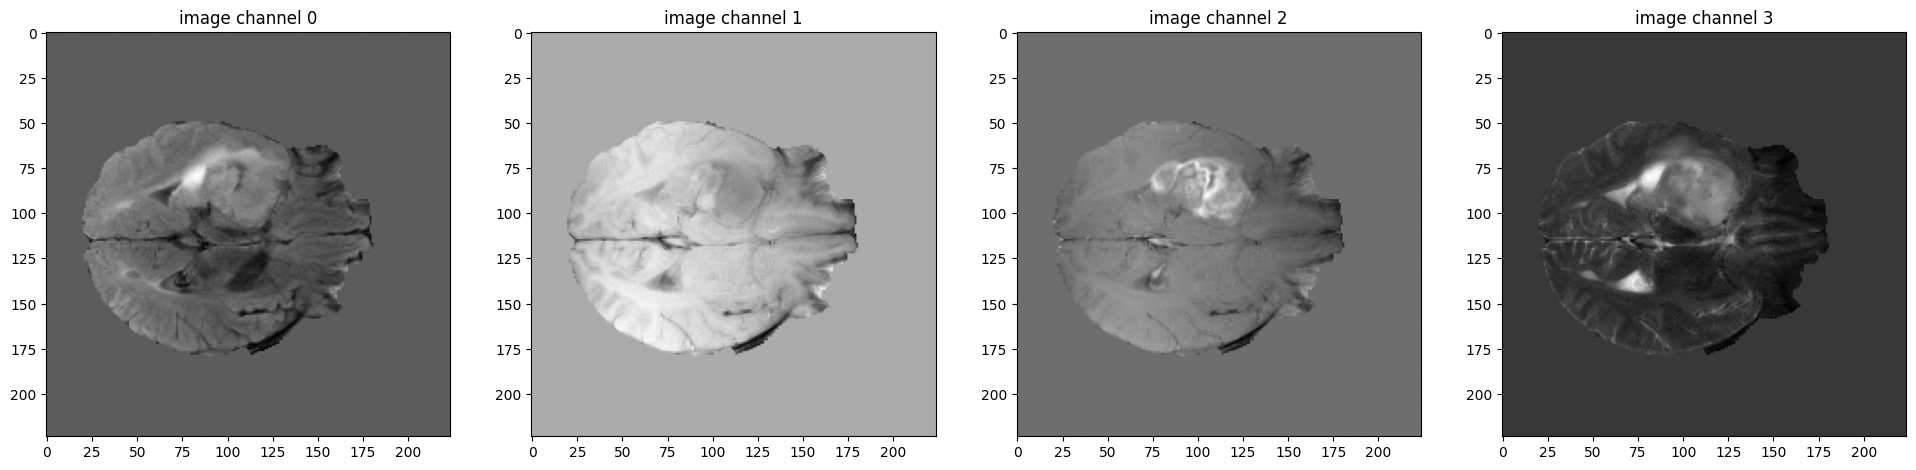

label shape: torch.Size([3, 224, 224, 144])


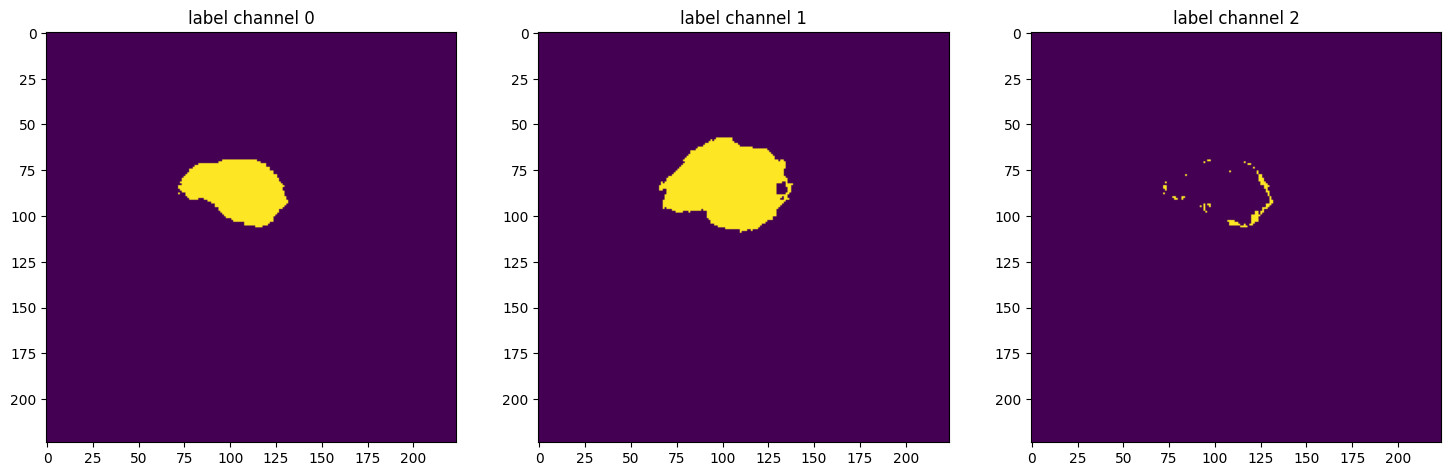

In [10]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
N = len(val_ds)
# extra random call so below example has a tumor
random.randint(0,N-1)
idx = random.randint(0,N-1)
print(f"showing example {idx}")
val_data_example = val_ds[idx]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

# TODO : change this to the better grayscale w/ red overlay for preds

## Create Model, Loss, Optimizer

In [12]:
if torch.cuda.is_available() :
    device = torch.device("cuda")
else :
    device = torch.device("cpu")

import torchvision.models
from custom_sam3d.model import CustomSAM3D

In [13]:
max_epochs = MAX_EPOCHS
val_interval = VAL_EVERY
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
# model = SegResNet(
#     blocks_down=[1, 2, 2, 4],
#     blocks_up=[1, 1, 1],
#     init_filters=16,
#     in_channels=4,
#     out_channels=3,
#     dropout_prob=0.2,
# ).to(device)
model = CustomSAM3D(in_channels=4, out_channels=3, kernel_size=5).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True) # SIGMOID = TRUE
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

load_prev_checkpoint = LOAD_PREVIOUS_CHECKPOINT
checkpoint_stats_path = os.path.join(MODEL_DIRECTORY, CHECKPOINT_STATS_NAME)
checkpoint_model_path = os.path.join(MODEL_DIRECTORY, CHECKPOINT_MODEL_NAME)
checkpoint_optimizer_path = os.path.join(MODEL_DIRECTORY, CHECKPOINT_OPTIMIZER_NAME)
checkpoint_lr_scheduler_path = os.path.join(MODEL_DIRECTORY, CHECKPOINT_LEARNING_RATE_SCHEDULER_NAME)
best_model_path = os.path.join(MODEL_DIRECTORY, BEST_MODEL_NAME)
if load_prev_checkpoint:
    print("loading previously checkpointed model/optimizer/lr_scheduler states")
    model.load_state_dict(torch.load(checkpoint_model_path, map_location=device))
    optimizer.load_state_dict(torch.load(checkpoint_optimizer_path, map_location=device))
    lr_scheduler = torch.load(checkpoint_lr_scheduler_path, weights_only=False, map_location=device)

# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(144, 224, 224),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.amp.autocast('cuda'):
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.amp.GradScaler('cuda')
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

loading previously checkpointed model/optimizer/lr_scheduler states


## Execute a typical PyTorch training process

In [14]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
cumulative_time = 0

if load_prev_checkpoint:
    print("loading previously checkpointed epoch plot statistics")
    loaded_checkpoint = torch.load(checkpoint_stats_path)
    epoch = loaded_checkpoint['epoch']
    best_metric = loaded_checkpoint['best_metric']
    best_metric_epoch = loaded_checkpoint['best_metric_epoch']
    epoch_loss_values = loaded_checkpoint['epoch_loss_values']
    metric_values = loaded_checkpoint['metric_values']
    metric_values_wt = loaded_checkpoint['metric_values_wt']
    metric_values_et = loaded_checkpoint['metric_values_et']
    metric_values_tc = loaded_checkpoint['metric_values_tc']
    cumulative_time = loaded_checkpoint['cumulative_time']
    print("epoch:", epoch)
    print("best_metric:", best_metric)
    print("best_metric_epoch:", best_metric_epoch)
    print('epoch_loss_values:', epoch_loss_values)
    print('metric_values:', metric_values)
    print('metric_values_tc:', metric_values_tc)
    print('metric_values_wt:', metric_values_wt)
    print('metric_values_et:', metric_values_et)
    print('cumulative_time:', cumulative_time)

total_start = time.time()
# start from last epoch
# if first time, starts from 0
for epoch in range(len(epoch_loss_values), max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        # inputs shape (N, C, H, W, D): (1, 4, 224, 224, 144)
        inputs = inputs.permute(0, 1, 4, 2, 3) # now (N, C, D, H, W) for torch
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            outputs = outputs.permute(0, 1, 3, 4, 2) # now (N, C, H, W, D) for MONAI
            loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        epoch_loss += loss.item()
        if step % PRINT_EVERY == 0 :
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
                f", step time: {(time.time() - step_start):.4f}"
            )

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_inputs = val_inputs.permute(0, 1, 4, 2, 3) # now (N, C, D, H, W) for torch
                val_outputs = inference(val_inputs)
                val_outputs = val_outputs.permute(0, 1, 3, 4, 2) # now (N, C, H, W, D) for MONAI
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(model.state_dict(), best_model_path)
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    # print plot statistics
    print("epoch_loss_values:", epoch_loss_values)
    print("metric_values:", metric_values)
    print("metric_values_tc:", metric_values_tc)
    print("metric_values_wt:", metric_values_wt)
    print("metric_values_et:", metric_values_et)
    # save training checkpoint
    torch.save(model.state_dict(), checkpoint_model_path)
    torch.save(optimizer.state_dict(), checkpoint_optimizer_path)
    torch.save(lr_scheduler, checkpoint_lr_scheduler_path)
    torch.save(
        {
            'epoch': epoch+1,
            'best_metric': best_metric,
            'best_metric_epoch': best_metric_epoch,
            'epoch_loss_values': epoch_loss_values,
            'metric_values': metric_values,
            'metric_values_wt': metric_values_wt,
            'metric_values_et': metric_values_et,
            'metric_values_tc': metric_values_tc,
            'cumulative_time': time.time() - total_start + cumulative_time
        },
        checkpoint_stats_path)
    print("saved training checkpoint for epoch", epoch+1)

total_time = time.time() - total_start + cumulative_time

loading previously checkpointed epoch plot statistics
epoch: 12
best_metric: 0.7206999659538269
best_metric_epoch: 11
epoch_loss_values: [0.40972995880952817, 0.305234278945886, 0.27644013479044754, 0.26528319829748465, 0.25753901131719964, 0.24518218740206404, 0.2350439532592739, 0.23258564246760816, 0.22970258241000863, 0.2256161601753118, 0.21949996533275573, 0.222996283514598]
metric_values: [0.6092737913131714, 0.6638341546058655, 0.6496498584747314, 0.6903355717658997, 0.6857102513313293, 0.693152129650116, 0.6955086588859558, 0.7082881927490234, 0.7113780975341797, 0.7028887867927551, 0.7206999659538269, 0.7130087018013]
metric_values_tc: [0.6303269267082214, 0.7119998335838318, 0.6862899661064148, 0.7419435381889343, 0.7367132306098938, 0.739170253276825, 0.7398035526275635, 0.7518952488899231, 0.7579463124275208, 0.7444276213645935, 0.7674514651298523, 0.7604169845581055]
metric_values_wt: [0.8027634024620056, 0.8302514553070068, 0.8323392868041992, 0.8508472442626953, 0.85524

In [15]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.7207 at epoch: 11, total time: 13178.763844013214.


## Plot the loss and metric

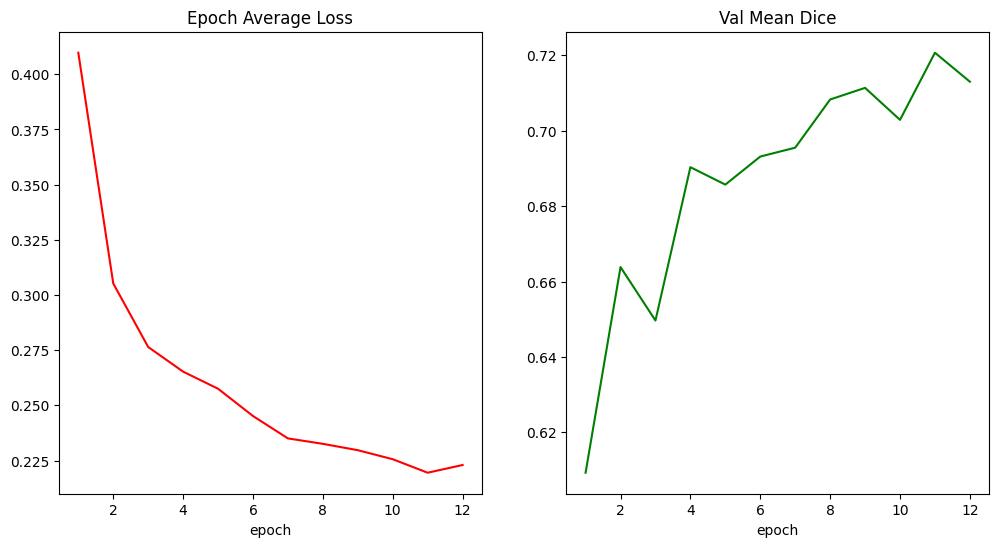

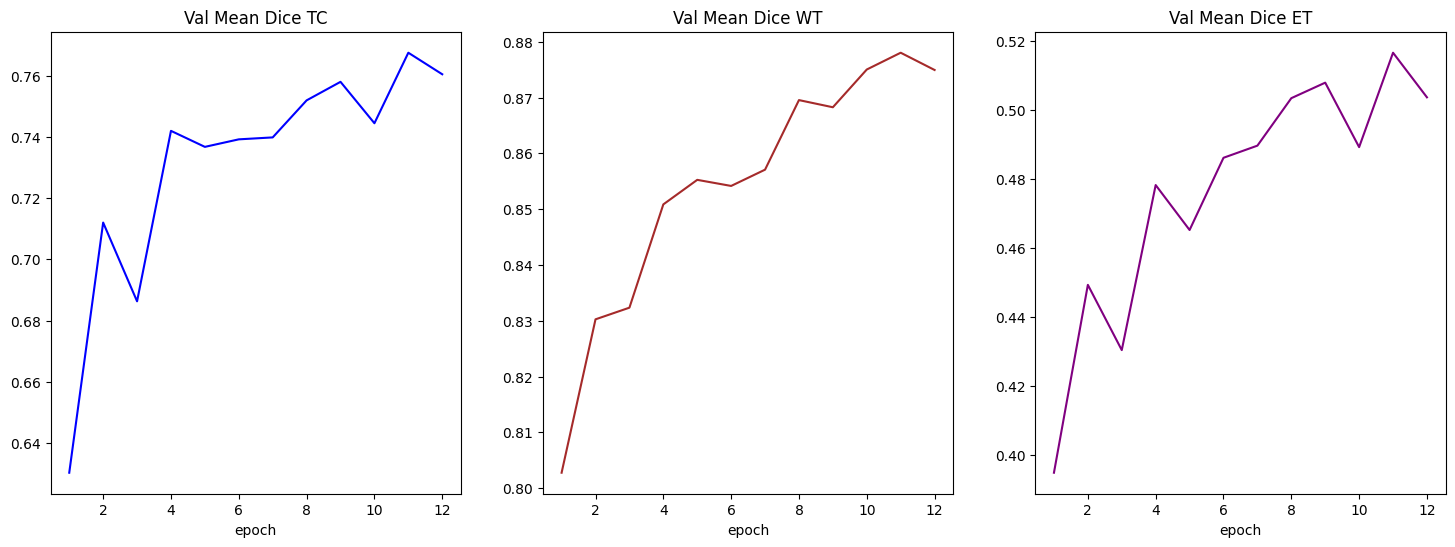

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best model output with the input image and label

In [17]:
random.randint(0,N-1)
random.randint(0,N-1)

50

In [18]:
model.load_state_dict(torch.load(best_model_path))
model.eval()
with torch.no_grad():
    idx = 65
    # select one image to evaluate and visualize the model output
    val_input = val_ds[idx]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_input = val_input.permute(0, 1, 4, 2, 3) # now (N, C, D, H, W) for torch
    val_output = inference(val_input)
    val_output = val_output.permute(0, 1, 3, 4, 2) # now (N, C, H, W, D) for MONAI
    val_output = post_trans(val_output[0])

    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[idx]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.savefig('/content/drive/MyDrive/custom-sam-3d/figures/pred_input.png')
    plt.close()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    background = val_ds[idx]['image'][2,:,:,70]
    background = (background - background.min()) / (background.max() - background.min())
    background_rgb = background.unsqueeze(-1).repeat(1, 1, 3)  # (H, W, 3)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        new_background = background_rgb.clone()
        mask = val_ds[idx]['label'][i,:,:,70] == 1
        new_background[...,0][mask] = 1.0
        new_background[...,1][mask] = 0.0
        new_background[...,2][mask] = 0.0
        plt.imshow(new_background.detach().cpu().numpy())
    plt.savefig('/content/drive/MyDrive/custom-sam-3d/figures/pred_label.png')
    plt.close()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        new_background = background_rgb.clone()
        mask = val_output[i,:,:,70] == 1
        new_background[...,0][mask] = 1.0
        new_background[...,1][mask] = 0.0
        new_background[...,2][mask] = 0.0
        plt.imshow(new_background.detach().cpu().numpy())
    plt.savefig('/content/drive/MyDrive/custom-sam-3d/figures/pred_output.png')
    plt.close()

## Evaluation on original image spacings

In [19]:
val_org_transforms = test_transform
val_org_ds = test_ds
val_org_loader = test_loader
post_transforms = post_transform

In [20]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_inputs = val_inputs.permute(0, 1, 4, 2, 3) # now (N, C, D, H, W) for torch
        val_data["pred"] = inference(val_inputs)
        val_data["pred"] = val_data["pred"].permute(0, 1, 3, 4, 2) # now (N, C, H, W, D) for MONAI
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.720440149307251
metric_tc: 0.7672
metric_wt: 0.8777
metric_et: 0.5165


## Unassign runtime

If using Google Colab, run this cell to end your current runtime.  
Useful when running a long training session and stepping away.

In [ ]:
from google.colab import runtime
runtime.unassign()